# CE9010 Data Science Project 
### ( - A Look into rental fee on PropertyGuru - )
--------------------
<b>Name         : Chong Ke Xin</b>
<br>
<b>Matric number: U1440121F</b>
<br>
<b>Group ID     : 9 ( 3:15-3:22pm )</b>
<br><br>
This report predicts price range of rental fee base on 5 variables such as distance from MRT station (within 1km), property size, number of bedrooms, number of bathromms, and which MRT stations on East-West line.
<br><br>
This report aims to provide prediction on the rental fee such that people will not suffered from overprice rental fee.

In [38]:
import pandas as pd
import numpy as np
import time

# Machine learning library
import sklearn
from sklearn.model_selection import train_test_split
# - Random Forest
from sklearn.ensemble import RandomForestClassifier
# - Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.preprocessing import OneHotEncoder
# - Cross validation
from sklearn.model_selection import KFold

# Cleaning data
import re

# Remove warning
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Visualization
import seaborn as sns
%matplotlib inline
from IPython.display import set_matplotlib_formats
from IPython.display import display, HTML
set_matplotlib_formats('png2x','pdf')
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from IPython.display import display_html

\* For the data file, please refer to other three files on data collecting procedure.

### Step 2: Data acquisition

In [2]:
data = pd.read_csv('data/data.csv',index_col = 'index')

In [3]:
data.iloc[:15,:]

,name,details,size,address,available time,bed,bath,price,nearest MRT ID,distance
index,,,,,,,,,,
0,Coco Palms,Partially Furnished Condominium,904 sqft,Pasir Ris Drive 1,Ready to move,3,2,"S$ 2,999 /mo",EW1 Pasir Ris MRT Station,0.42 km
1,D'Nest,Partially Furnished Condominium,484 sqft,129 Pasir Ris Grove,Ready to move,1,1,"S$ 1,850 /mo",EW1 Pasir Ris MRT Station,0.53 km
2,D'Nest,Fully Furnished Condominium,743 sqft,Pasir Ris Grove,Ready to move,2,2,"S$ 2,350 /mo",EW1 Pasir Ris MRT Station,0.53 km
3,NV Residences,Fully Furnished Condominium,1087 sqft,87 Pasir Ris Grove,Ready to move,3,2,"S$ 2,800 /mo",EW1 Pasir Ris MRT Station,0.54 km
4,Livia,Partially Furnished Condominium,1539 sqft,69 Pasir Ris Grove,Ready to move,4,4,"S$ 3,499 /mo",EW1 Pasir Ris MRT Station,0.82 km
5,The Palette,Partially Furnished Condominium,1377 sqft,103 Pasir Ris Grove,Ready to move,4,3,"S$ 3,400 /mo",EW1 Pasir Ris MRT Station,0.53 km
6,Coco Palms,Partially Furnished Condominium,742 sqft,Pasir Ris Drive 1,Available from 20 Apr,2,2,"S$ 2,400 /mo",EW1 Pasir Ris MRT Station,0.42 km
7,Coco Palms,Fully Furnished Condominium,464 sqft,29 Pasir Ris Grove,Ready to move,Studio,0,"S$ 2,000 /mo",EW1 Pasir Ris MRT Station,0.42 km
8,D'Nest,Fully Furnished Condominium,936 sqft,Pasir Ris Grove,S$ 2.62 psf,3,2,"S$ 2,450 /mo",EW1 Pasir Ris MRT Station,0.53 km


<center>Table 1 - raw data scrapped from PropertyGuru</center>

In [5]:
data.shape

(24522, 10)

In [4]:
data.reset_index(inplace=True,drop=True)

#Remove unwanted information from the data
data.drop(['address','available time'],inplace=True,axis=1)
#Only consider data with distance available
data.dropna(subset=['distance'],inplace=True)

#Extracting out the features from raw data
data['price']=[int(re.search(' (.)* ',data.iloc[i].price).group().replace(',','')) for i in range(len(data['price'])) if re.search(' (.)* ',data.iloc[i].price) is not None ]
data['size'] = [re.findall('\d+',data['size'].iloc[i])[0] if len(re.findall('\d+',data['size'].iloc[i]))>0 else '' for i in range(len(data))]
data['distance'] = [re.findall('(.*) km',data['distance'].iloc[i])[0] for i in range(len(data))]

#Removing duplicate data
data.drop_duplicates(subset=['name','size','bed','bath','nearest MRT ID','distance'],inplace=True)

#Change all the numeric data from string to float or integer
temp = [int(data['bed'].iloc[i]) if data['bed'].iloc[i].isdigit() else np.nan for i in range(len(data))]
data['bed'] = temp
data['bath'] = data['bath'].astype(float)
data['size'] = data['size'].astype(float)
data['distance'] = data['distance'].astype(float)

data.dropna(inplace=True)

#Calculate the statistic of the data according to MRT stations
data_stat = pd.DataFrame(columns=['MRT ID','number_of_samples','min price(S$)','mean price(S$)','median price(S$)','max price(S$)'])
p=data.groupby(by='nearest MRT ID')
i = 0
for grp, temp in p:
    temp_data = [grp,len(temp),temp['price'].min(),temp['price'].mean(),temp['price'].median(),temp['price'].max()]
    data_stat.loc[i] = temp_data
    i = i+1

### Classify data into different classes by their price range:
                   class 0 : 1-500                    class 5 : 2501-3000 
                   class 1 : 501-1000                 class 6 : 3001-3500
                   class 2 : 1001-1500                class 7 : 3501-4000
                   class 3 : 1501-2000                class 8 : 4001-4500
                   class 4 : 2001-2500                class 9 : > 4500

In [5]:
data['price']  = data['price'].astype(int)

last_class = 9
# Initialize the class indicator to be last class first
data['Price indi']=[last_class for i in range(len(data))]

# run until (last_class-1), every records that is not belonging to class 0 - class (last_class-1) will be automatically 
#   become last class
for k in range(last_class):
    for i in range(len(data)):
        if data.price.iloc[i] >= 1+500*k and data.price.iloc[i] <= 500*k+500:
            data['Price indi'].iloc[i] = k
            
# Representing MRT station name in number instead of the name
# Follows the order in available_MRT.csv, i.e. the representing number is the index in the csv file
mrt_list = data['nearest MRT ID'].unique()
for i in range(len(mrt_list)):
    data['nearest MRT ID'] = data['nearest MRT ID'].replace(mrt_list[i],i)

# One-hot-encoding for MRT station feature
one_hot_encoding = pd.get_dummies(data['nearest MRT ID'])

# For one-hot-encoding, always delete one variable
del one_hot_encoding[27]


C:\Users\Admin\Anaconda3\envs\CE9010_2018\lib\site-packages\pandas\core\indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [6]:
data.iloc[:10,:]

,name,details,size,bed,bath,price,nearest MRT ID,distance,Price indi
0,Coco Palms,Partially Furnished Condominium,904.0,3.0,2.0,2999,0,0.42,5
1,D'Nest,Partially Furnished Condominium,484.0,1.0,1.0,1850,0,0.53,3
2,D'Nest,Fully Furnished Condominium,743.0,2.0,2.0,2350,0,0.53,4
3,NV Residences,Fully Furnished Condominium,1087.0,3.0,2.0,2800,0,0.54,5
4,Livia,Partially Furnished Condominium,1539.0,4.0,4.0,3499,0,0.82,6
5,The Palette,Partially Furnished Condominium,1377.0,4.0,3.0,3400,0,0.53,6
6,Coco Palms,Partially Furnished Condominium,742.0,2.0,2.0,2400,0,0.42,4
8,D'Nest,Fully Furnished Condominium,936.0,3.0,2.0,2450,0,0.53,4
9,Coco Palms,Partially Furnished Condominium,743.0,2.0,2.0,2499,0,0.42,4
10,D'Nest,Partially Furnished Condominium,753.0,2.0,2.0,2150,0,0.53,4


                                   Table 2 - Cleaned data 

In [9]:
#Remaining data after cleaning
data.shape

(10262, 9)

### Step 3: Data exploration & Step 4: Pre-processing

In [10]:
stat = {'min':data['price'].min(),'mean':data['price'].mean(),'median':data['price'].median(),
        'max':data['price'].max()}
print(stat)
stat2 = {'25% quantile':data['price'].quantile(q=0.25),'50% quantile':data['price'].quantile(q=0.5),'75% quantile':data['price'].quantile(q=0.75)}
print(stat2)

{'min': 230, 'mean': 3700.0913077372834, 'median': 3000.0, 'max': 35000}
{'25% quantile': 2300.0, '50% quantile': 3000.0, '75% quantile': 4200.0}


75% of the data is below S\$4,200, but the maximun rental fee is S\$35,000. Hence, classify data with price greater than S$4,500 to only one class.

In [11]:
data_stat2 = data.copy()
del data_stat2['price']
del data_stat2['nearest MRT ID']
data_stat2 = pd.concat([data_stat2,one_hot_encoding])
data_stat2 = pd.concat([data_stat2.mean().to_frame('mean'),data_stat2.var().to_frame('var')],axis=1)

def display_side_by_side(*args):
    html_str=''
    for df in args:
        html_str+=df.to_html()
    display_html(html_str.replace('table','table style="display:inline"'),raw=True)

display_side_by_side(data_stat2.iloc[:10,:],data_stat2.iloc[10:20,:],data_stat2.iloc[20:30,:],
                     data_stat2.iloc[30:,:])

,mean,var
size,1149.847496,908477.412370
bed,2.417560,1.020150
bath,1.990450,0.879745
distance,0.618891,0.067250
Price indi,5.729682,4.973798
0,0.025239,0.024604
1,0.017346,0.017046
2,0.022900,0.022378
3,0.044338,0.042377
4,0.032157,0.031126


                     Table 3 - mean and variance of each festure of all data

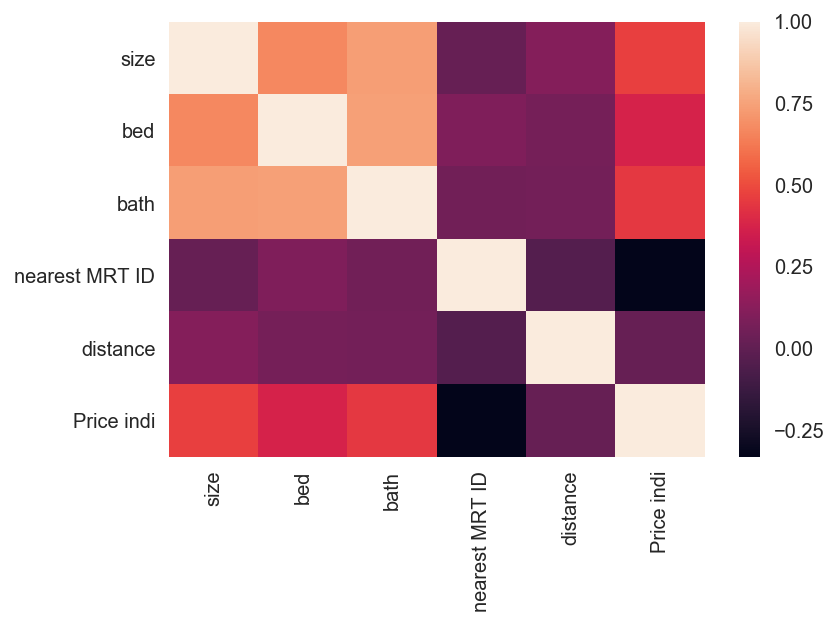

In [12]:
data1 = data.copy()
del data1['price']
plt.figure(1)
sns.set()
ax = sns.heatmap(data1.loc[:,'size':'Price indi'].corr())

             Fig 1 - Correlation heatmap

Except distance, nearest MRT ID, number of bathrooms, number of bedrooms, and size of the house are quite significant to price indi.

In [13]:
# Sorting MRT station according to the station number
temp = data_stat['MRT ID']
temp = [int(temp.iloc[i].split(' ')[0][2:]) for i in range(len(temp))]
data_stat['No'] = temp
data_stat.sort_values('No',inplace=True)
#del data_stat['No']

data_stat.style

,MRT ID,number_of_samples,min price(S$),mean price(S$),median price(S$),max price(S$),No
0,EW1 Pasir Ris MRT Station,259,550,2607.44,2500,10000,1
11,EW2 Tampines MRT Station,170,600,2138.66,2200,3000,2
21,EW3 Simei MRT Station,249,650,2844.8,2550,8680,3
22,EW4 Tanah Merah MRT Station,358,600,3313.03,2800,12500,4
23,EW5 Bedok MRT Station,239,550,2493.41,2200,8000,5
24,EW6 Kembangan MRT Station,363,800,3405.15,2900,20000,6
25,EW7 Eunos MRT Station,405,380,3285.28,2800,15000,7
26,EW8 Paya Lebar MRT Station,446,550,3278.47,2800,12800,8
27,EW9 Aljunied MRT Station,595,650,2599.66,2400,10000,9
1,EW10 Kallang MRT Station,178,650,3170.98,2800,10000,10


<center> Table 4 - Statistis by each MRT station </center>

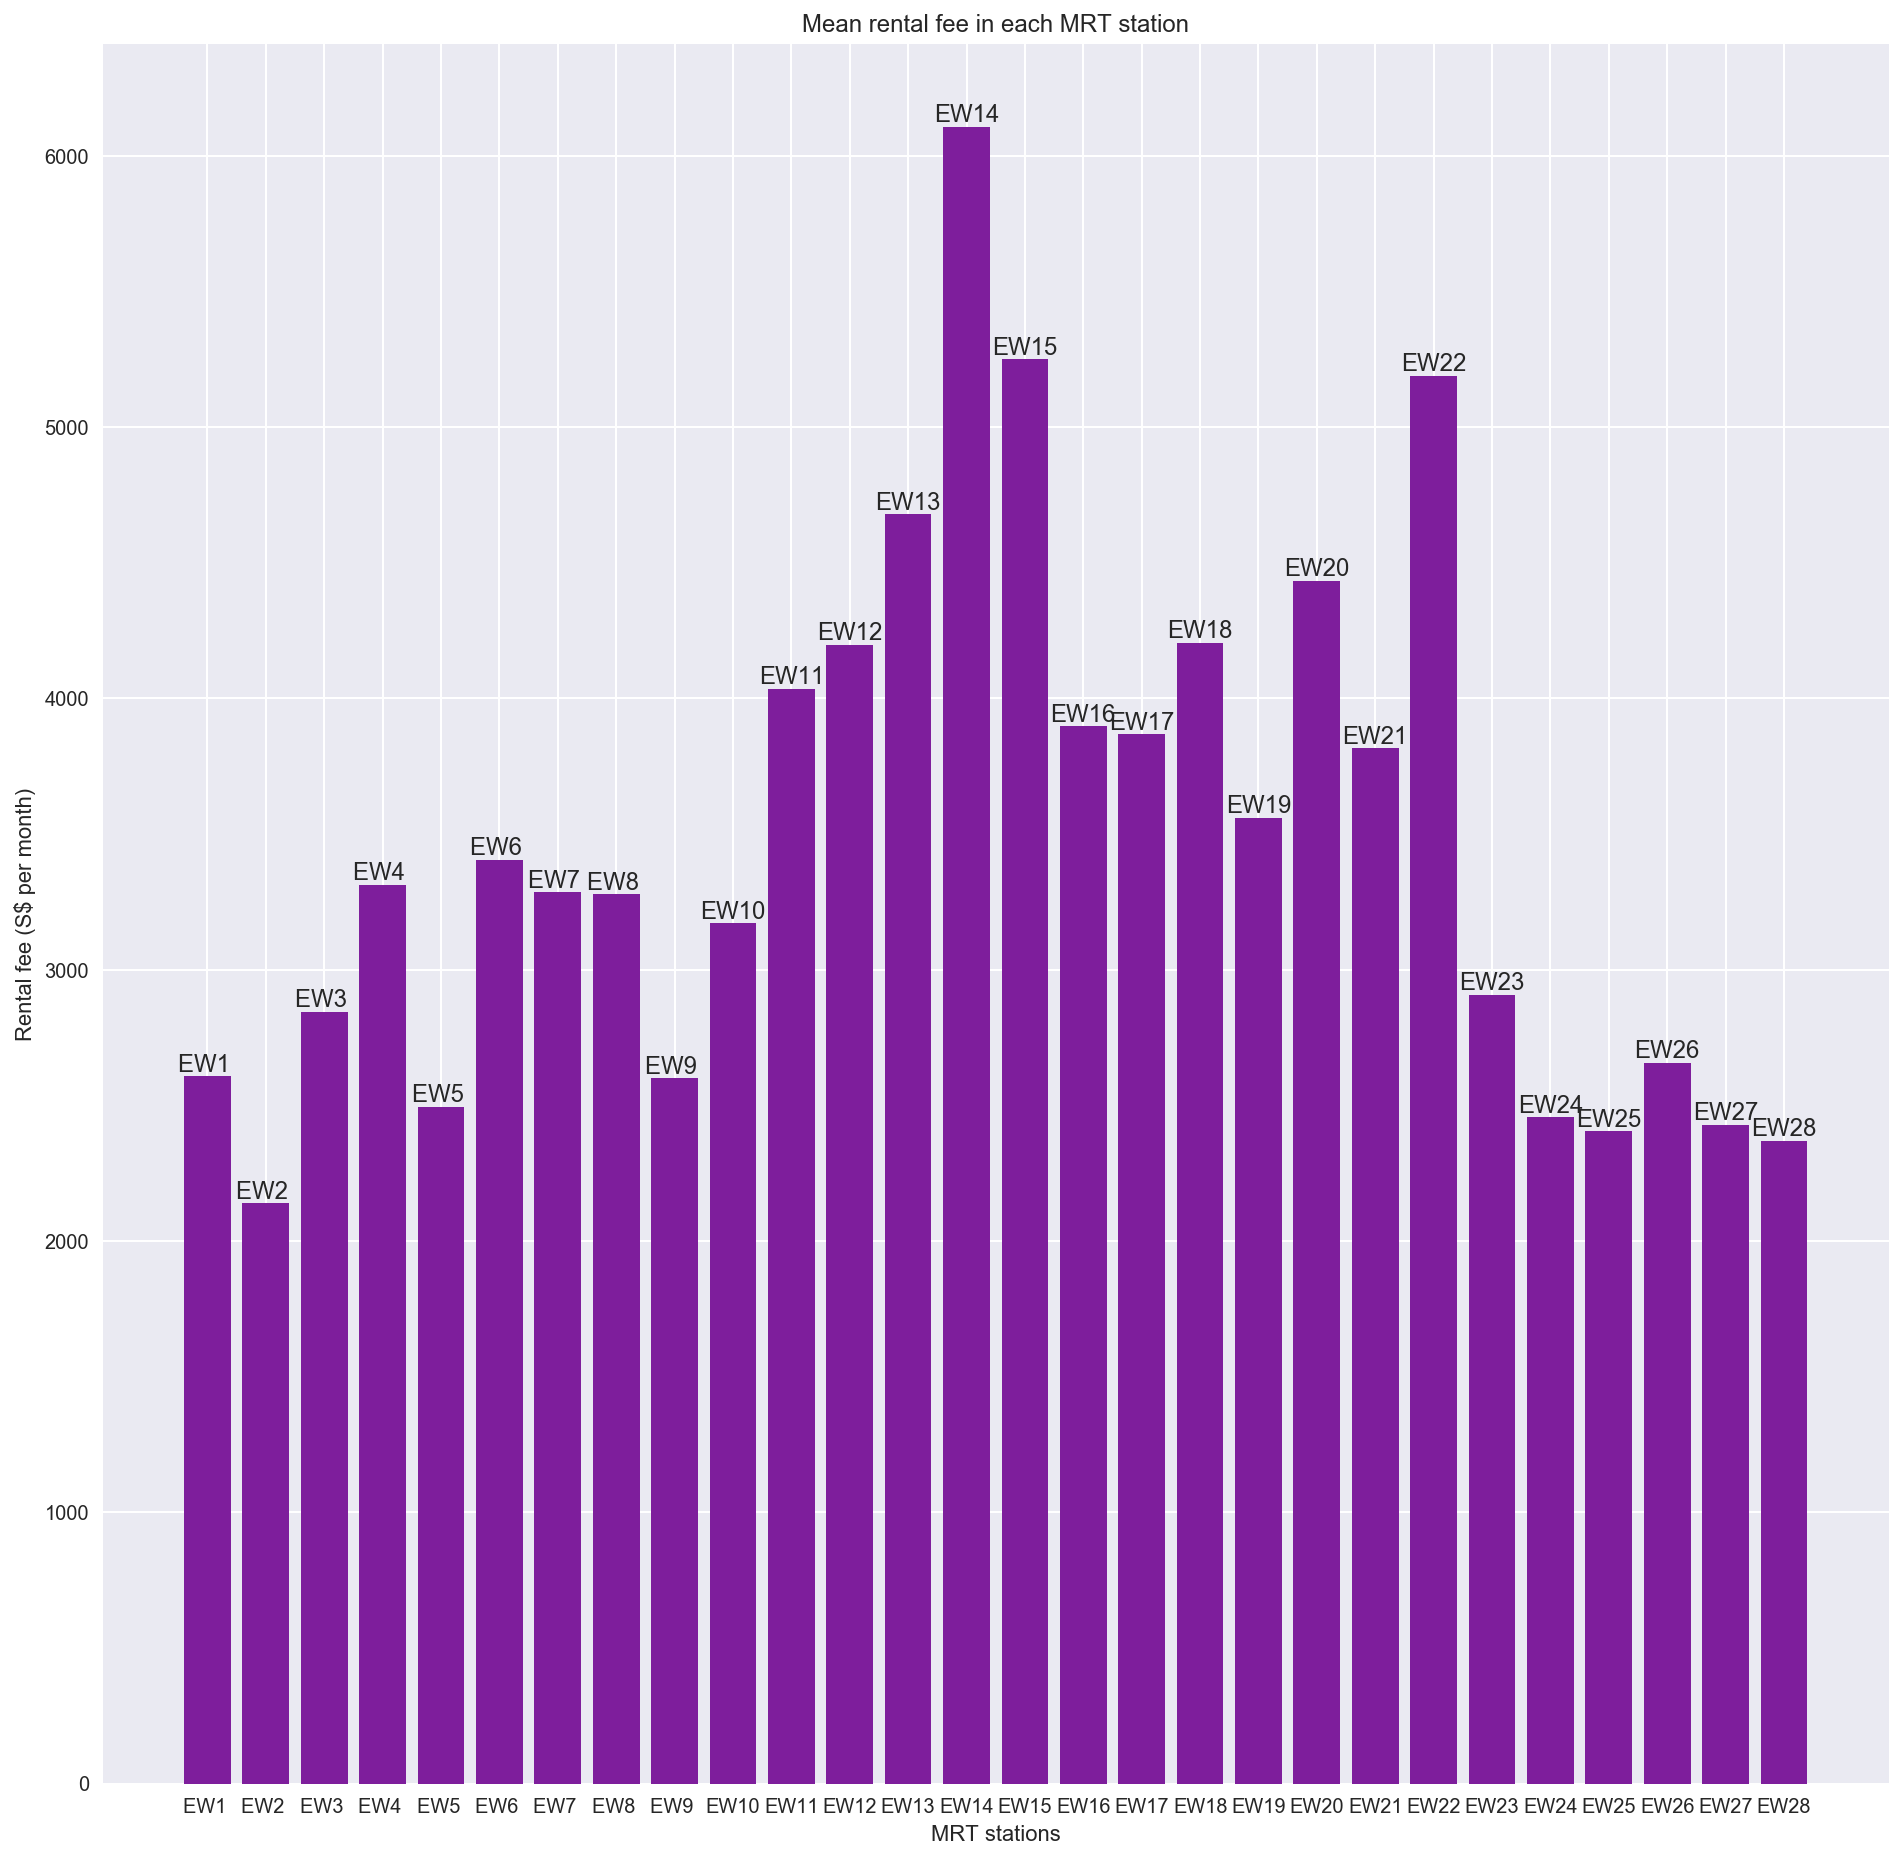

In [14]:
#Preparing data to plot
plt.figure(2,figsize=(16,16))
bar = plt.bar([data_stat['MRT ID'].iloc[i][:4] for i in range(len(data_stat))],
              data_stat['mean price(S$)'],color='xkcd:purple')

for i,rect in enumerate(bar):
    height = rect.get_height()
    plt.text(rect.get_x() + rect.get_width()/2.0, height, data_stat['MRT ID'].iloc[i][:4], 
             ha='center', va='bottom')
plt.title('Mean rental fee in each MRT station')
plt.xlabel('MRT stations')
plt.ylabel('Rental fee (S$ per month)')
plt.show()

#del data_stat['No']

<center> Fig 2- Mean rental fee in each MRT station </center>

Mean rental fee near <b>EW14 Raffles Place MRT station</b> is the highest.

In [15]:
# Classify data into different class for visualization
data_stat_PR = pd.DataFrame(columns=['Price Range','number_of_samples'])
p=data.groupby(by='Price indi')
i = 0
for grp, temp in p:
    temp_data = [grp,len(temp)]
    data_stat_PR.loc[i] = temp_data
    i = i+1

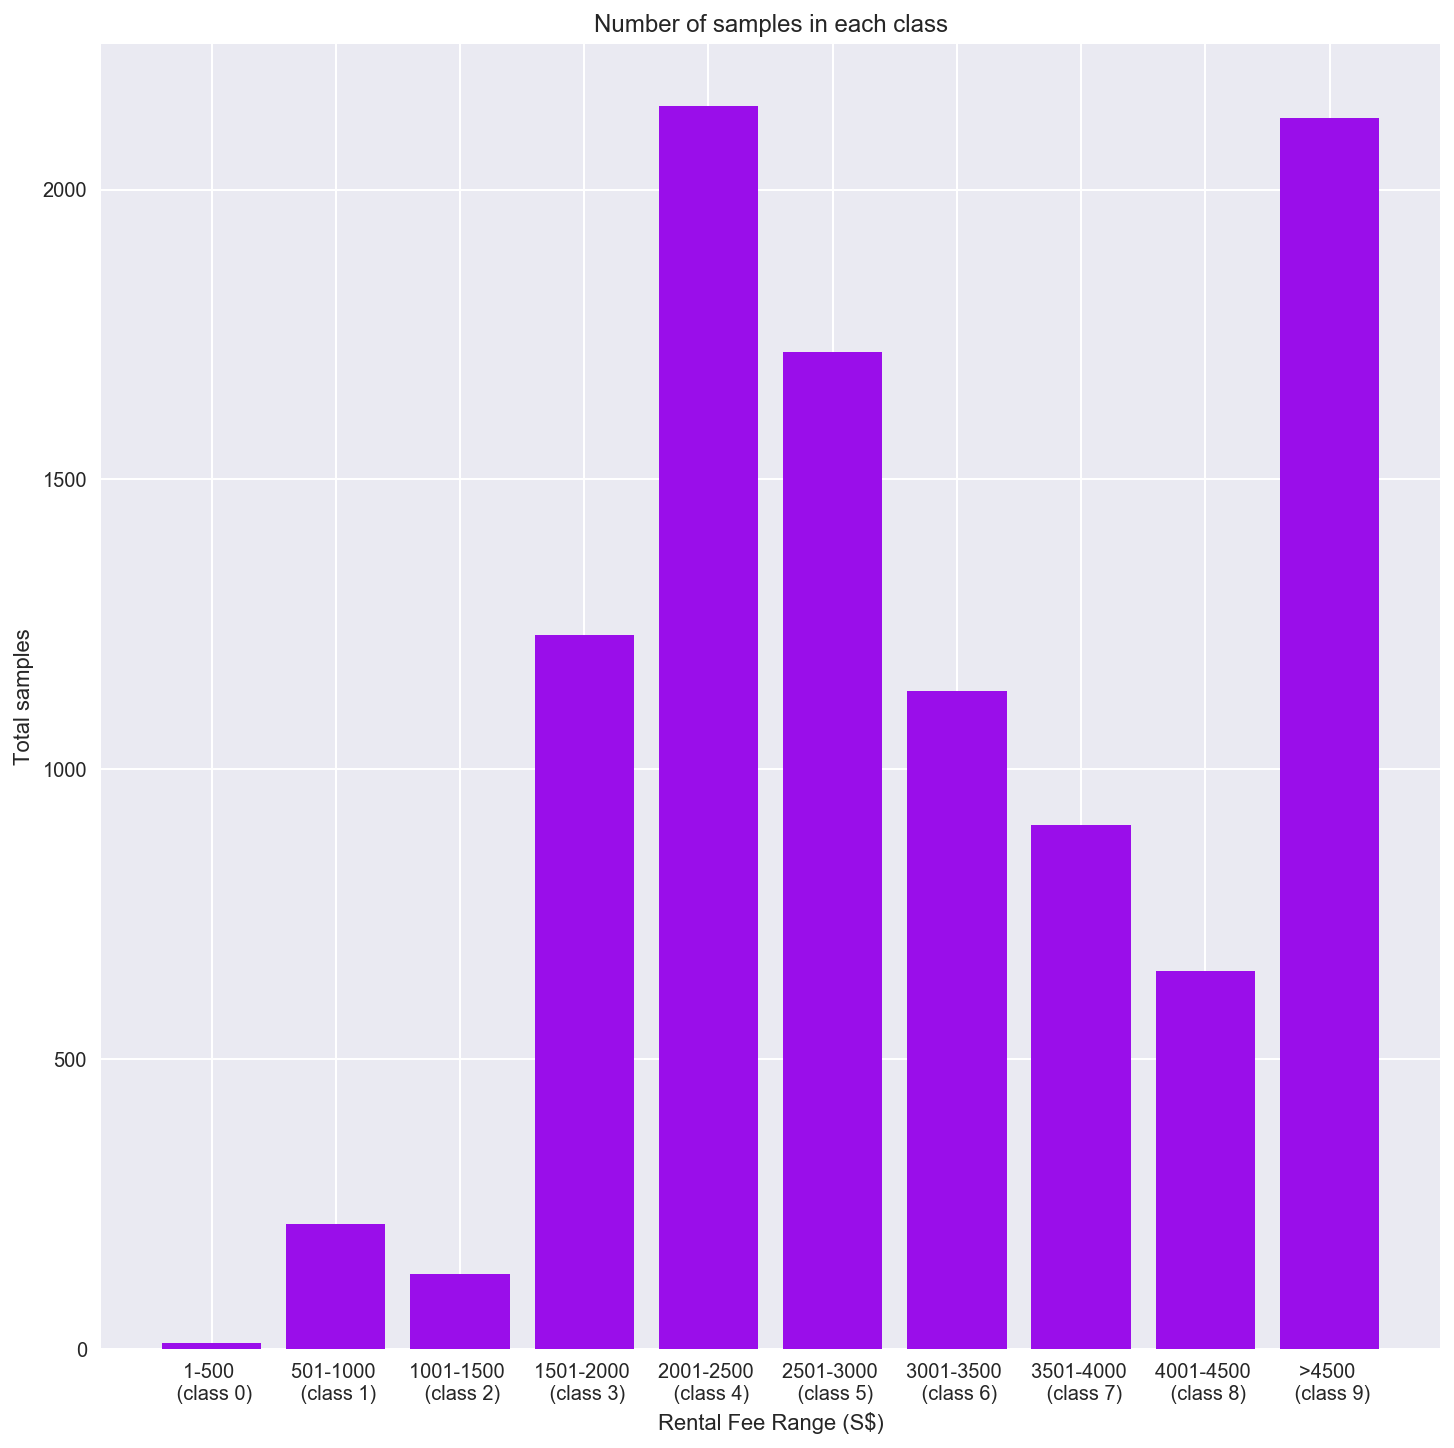

In [16]:
PR_x = ['%s-%s \n (class %s)'%(1+500*k,500*k+500,k) for k in range(9)]
PR_x.append('>4500 \n (class 9)')

plt.figure(3,figsize=(12,12))
plt.bar(PR_x,data_stat_PR['number_of_samples'],color='xkcd:violet')
plt.title('Number of samples in each class')
plt.xlabel("Rental Fee Range (S$)")
plt.ylabel("Total samples")
plt.show()

                          Fig 3 - Number of samples in each class

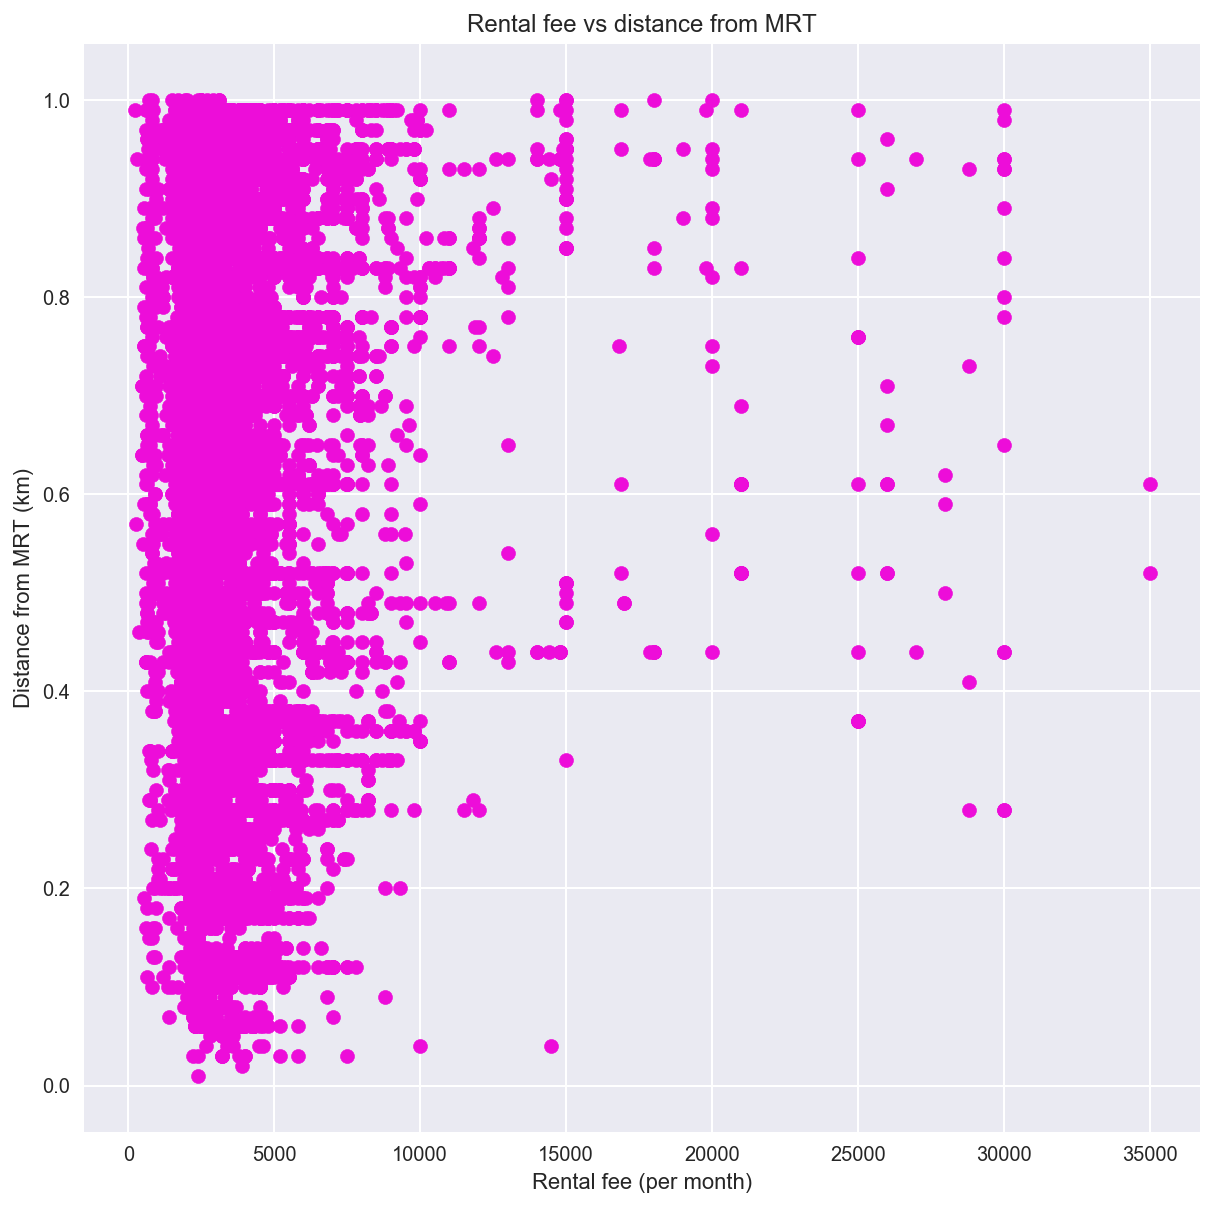

In [17]:
plt.figure(4,figsize=(10,10))
plt.scatter(data['price'],data['distance'],color='xkcd:fuchsia')
plt.title('Rental fee vs distance from MRT')
plt.xlabel('Rental fee (per month)')
plt.ylabel('Distance from MRT (km)')
plt.show()

                    Fig 4 - Rental fee vs distance from MRT 

Most of the data points cluster below S$5,000.

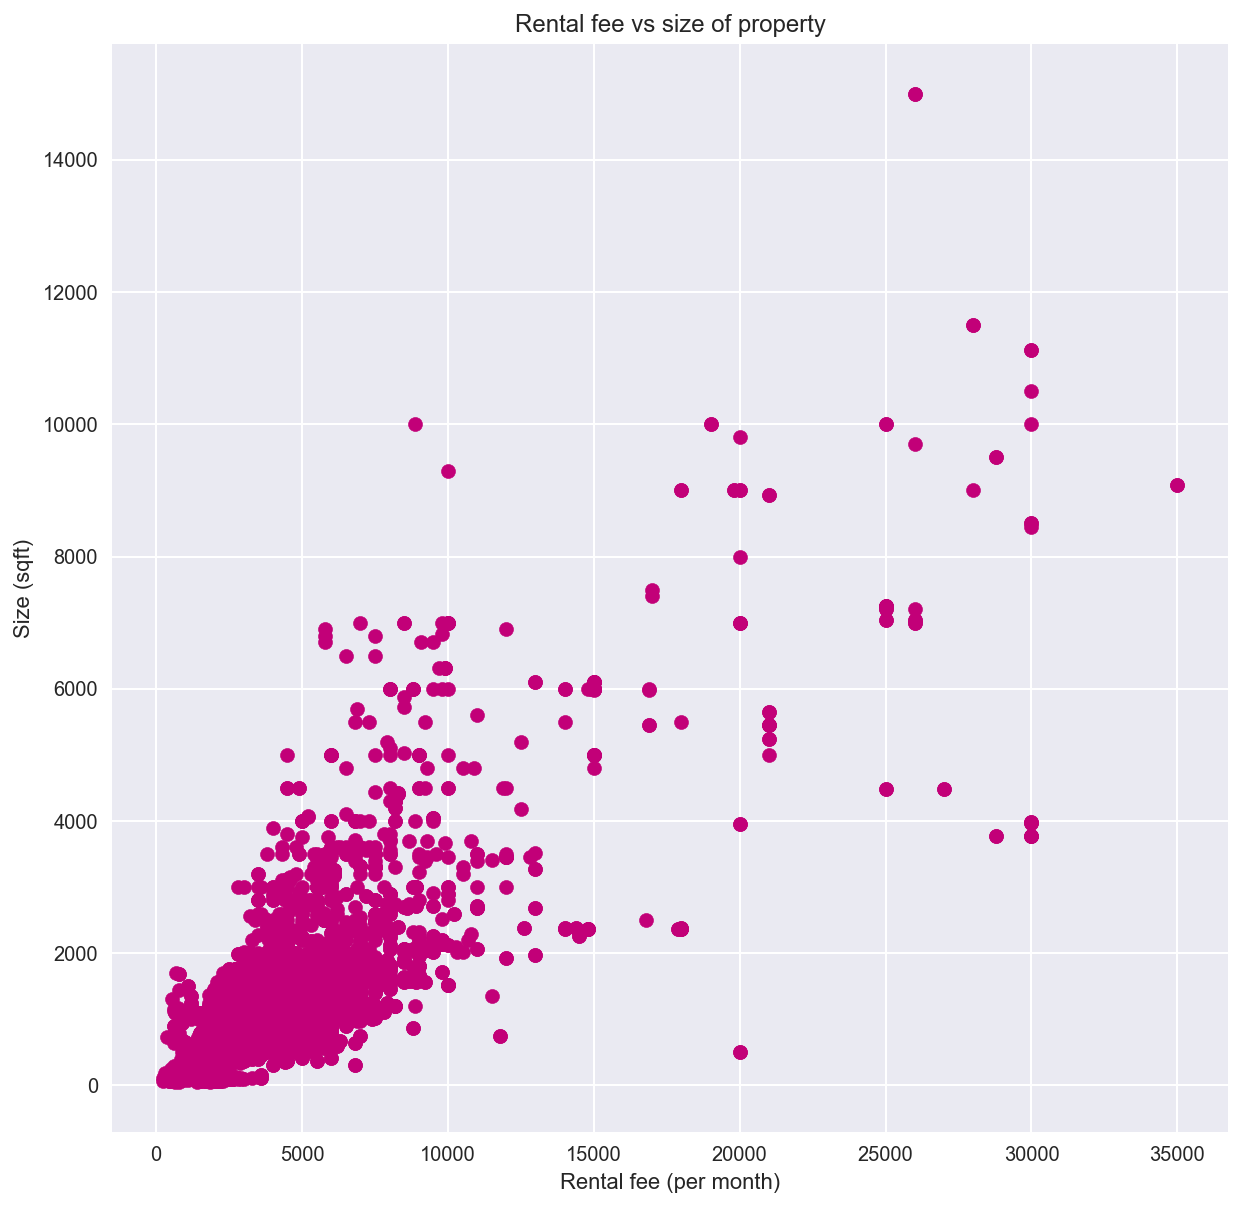

In [18]:

plt.figure(5,figsize=(10,10))
plt.scatter(data['price'],data['size'],color='xkcd:magenta')
plt.title('Rental fee vs size of property')
plt.xlabel('Rental fee (per month)')
plt.ylabel('Size (sqft)')
plt.show()

                     Fig 5 - Rental fee vs size of property

<function seaborn.utils.despine>

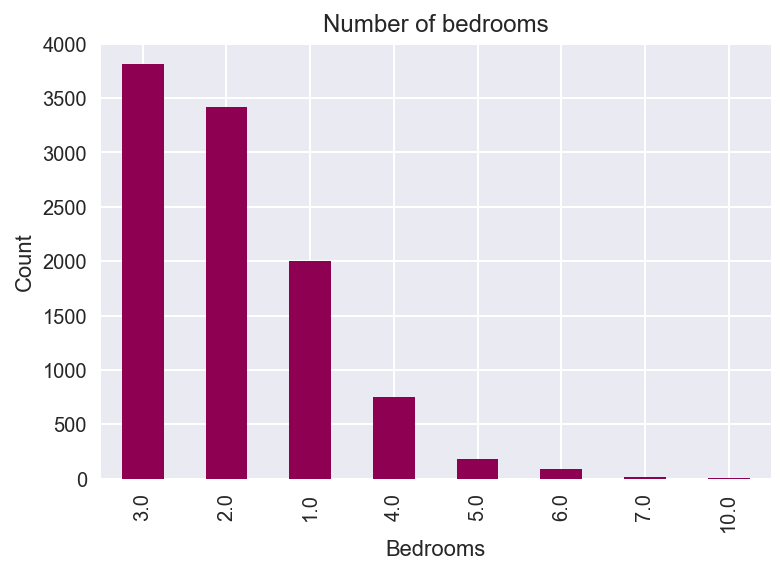

In [19]:
plt.figure(6)
data['bed'].value_counts().plot(kind='bar',colormap='PiYG')
plt.title('Number of bedrooms')
plt.xlabel('Bedrooms')
plt.ylabel('Count')
sns.despine

    Fig 6 - Number of bedrooms in each rental house

The most common numer of bedrooms in a rental house is 3.

<function seaborn.utils.despine>

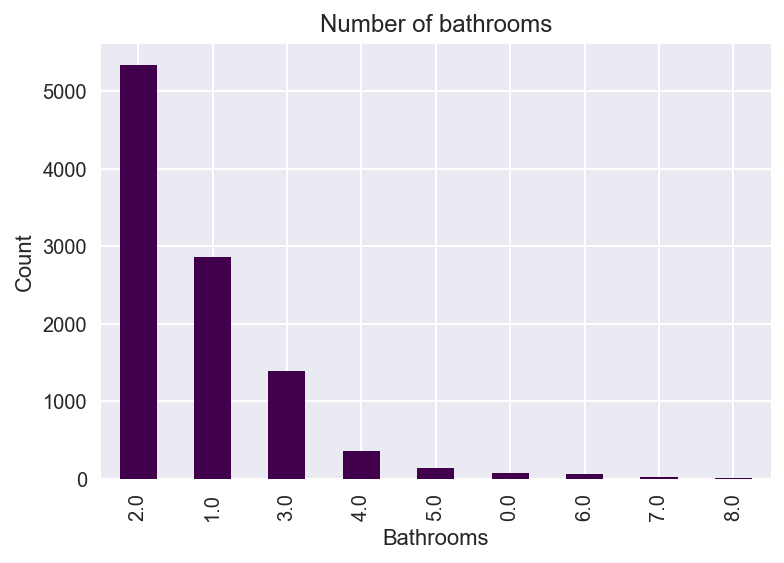

In [20]:
plt.figure(7)
data['bath'].value_counts().plot(kind='bar',colormap='PRGn')
plt.title('Number of bathrooms')
plt.xlabel('Bathrooms')
plt.ylabel('Count')
sns.despine

    Fig 7 - Number of bathrooms in each rental house

Similarly, the most common numer of bedrooms in a rental house is 2.

### Step 5: Data analysis & Step 6: Analysis of results

In [21]:
X = data.loc[:,'size':'distance']
X = pd.concat([X,one_hot_encoding],axis=1)
del X['nearest MRT ID']
del X['price']
y = data.loc[:,'Price indi']

data_train_x, data_test_x, data_train_y, data_test_y = train_test_split(X, y, test_size=0.2, random_state=42)
data_train_x.reset_index(inplace=True)
del data_train_x['index']
data_train_y.index = np.arange(len(data_train_y))

In [22]:
data_train_x.loc[:10,:]

,size,bed,bath,distance,0,1,2,3,4,5,...,17,18,19,20,21,22,23,24,25,26
0,700.0,2.0,2.0,0.74,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
1,796.0,2.0,2.0,0.93,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2066.0,3.0,2.0,0.42,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,1216.0,3.0,2.0,0.92,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1189.0,3.0,2.0,0.17,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,800.0,2.0,1.0,0.49,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
6,732.0,2.0,2.0,0.55,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1194.0,3.0,2.0,0.91,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
8,700.0,2.0,1.0,0.41,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,560.0,1.0,1.0,0.70,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


             Table 5 - Data features for training

\* Note that the number 0 to 26 is the one-hot encoding for the MRT stations.

### RandomForest

In [23]:
#Data normalization
data_train_mean = data_train_x.mean()
data_train_std = data_train_x.std()

data_train_x = (data_train_x - data_train_mean)/data_train_std
data_test_x = (data_test_x - data_train_mean)/data_train_std

In [24]:
start = time.time()
clf = RandomForestClassifier(n_estimators=1000)
clf.fit(data_train_x, data_train_y)
print('Time=',time.time() - start)

# Check accuracy
sklearn.metrics.accuracy_score(data_test_y, clf.predict(data_test_x))     

Time= 21.041686058044434


0.6385776911836337

In [25]:
# Confusion matrix
sklearn.metrics.confusion_matrix(data_test_y, clf.predict(data_test_x), 
                                 labels=None, sample_weight=None )

array([[  1,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  25,   2,   8,   8,   1,   0,   3,   1,   1],
       [  0,  11,   6,  11,   3,   1,   1,   0,   0,   2],
       [  0,   2,   4, 169,  69,   6,   4,   2,   2,   0],
       [  0,   2,   0,  56, 290,  54,  12,   3,   4,   1],
       [  0,   1,   0,   7,  69, 203,  32,  15,   4,  14],
       [  0,   0,   1,   1,  13,  42, 103,  26,  11,  13],
       [  0,   0,   0,   0,   5,  11,  34,  83,  40,  13],
       [  0,   0,   0,   0,   1,   4,  11,  19,  58,  31],
       [  0,   0,   0,   1,   3,  11,   1,   9,  24, 373]], dtype=int64)

Even though the accuracy is only 63.66%, from the confusion matrix we can see that, the mis-predicted classes are always lies one class above or below the actual class. Hence, it is still considered a good model.

### LogisticRegression

In [26]:
start = time.time()
logreg_sklearn = LogisticRegression(max_iter=300,C=1e6,solver='newton-cg',multi_class='multinomial') 
logreg_sklearn.fit(data_train_x, data_train_y) # learn the model parameters 
print('Time=',time.time() - start)

sklearn.metrics.accuracy_score(data_test_y, logreg_sklearn.predict(data_test_x))

Time= 17.107247352600098


0.48319532391622017

In [27]:
sklearn.metrics.confusion_matrix(data_test_y, logreg_sklearn.predict(data_test_x), 
                                 labels=None, sample_weight=None)

array([[  0,   1,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,  20,   0,  12,  12,   4,   0,   1,   0,   0],
       [  0,   8,   0,  14,   9,   2,   0,   0,   0,   2],
       [  0,   6,   0, 146,  85,  18,   0,   1,   0,   2],
       [  0,   3,   0,  62, 251,  75,  15,   3,   1,  12],
       [  0,   1,   0,  21,  94, 161,  23,   7,   4,  34],
       [  0,   0,   0,   8,  35,  80,  22,  13,   2,  50],
       [  0,   0,   0,   1,  15,  51,  36,  17,   1,  65],
       [  0,   0,   0,   0,   5,  32,  20,  11,   5,  51],
       [  0,   0,   0,   2,   3,  21,  11,   9,   6, 370]], dtype=int64)

### Cross Validation

In [34]:
def cv_normalize(data,train_index,test_index):
    #train_index and test_index are array
    data = (data-data.loc[train_index,:].mean())/data.loc[train_index,:].std()   
    return (data.loc[train_index,:], data.loc[test_index,:])

In [35]:
kf = KFold(n_splits=5)
cross_c = []
for C in [1e-6,1e-4,1,1e-2,1e2,1e4,1e6]:
    temp_cost = []
    for train_index, test_index in kf.split(data_train_x):
        print("TRAIN:", train_index, "TEST:", test_index)
        X_train, X_test = cv_normalize(data_train_x,train_index,test_index)
        # X_train, X_test = data_train_x.loc[train_index], data_train_x.loc[test_index]
        y_train, y_test = data_train_y.loc[train_index], data_train_y.loc[test_index]
        
        logreg_sklearn = LogisticRegression(max_iter=300,C=C,solver='newton-cg',
                                            multi_class='multinomial') 
        logreg_sklearn.fit(X_train, y_train) # learn the model parameters 
        
        # Check for loss
        one_hot = OneHotEncoder(n_values=10, sparse=False)

        y_true = one_hot.fit_transform(np.array(y_test).reshape(-1, 1))
        y_pred = one_hot.fit_transform(logreg_sklearn.predict(X_test).reshape(-1, 1))
        temp_cost.append(log_loss(y_true, y_pred))
        
    cross_c.append(np.mean(temp_cost))

TRAIN: [1642 1643 1644 ... 8206 8207 8208] TEST: [   0    1    2 ... 1639 1640 1641]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [1642 1643 1644 ... 3281 3282 3283]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [3284 3285 3286 ... 4923 4924 4925]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [4926 4927 4928 ... 6565 6566 6567]
TRAIN: [   0    1    2 ... 6565 6566 6567] TEST: [6568 6569 6570 ... 8206 8207 8208]
TRAIN: [1642 1643 1644 ... 8206 8207 8208] TEST: [   0    1    2 ... 1639 1640 1641]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [1642 1643 1644 ... 3281 3282 3283]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [3284 3285 3286 ... 4923 4924 4925]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [4926 4927 4928 ... 6565 6566 6567]
TRAIN: [   0    1    2 ... 6565 6566 6567] TEST: [6568 6569 6570 ... 8206 8207 8208]
TRAIN: [1642 1643 1644 ... 8206 8207 8208] TEST: [   0    1    2 ... 1639 1640 1641]
TRAIN: [   0    1    2 ... 8206 8207 8208] TEST: [1642 1643 1644 

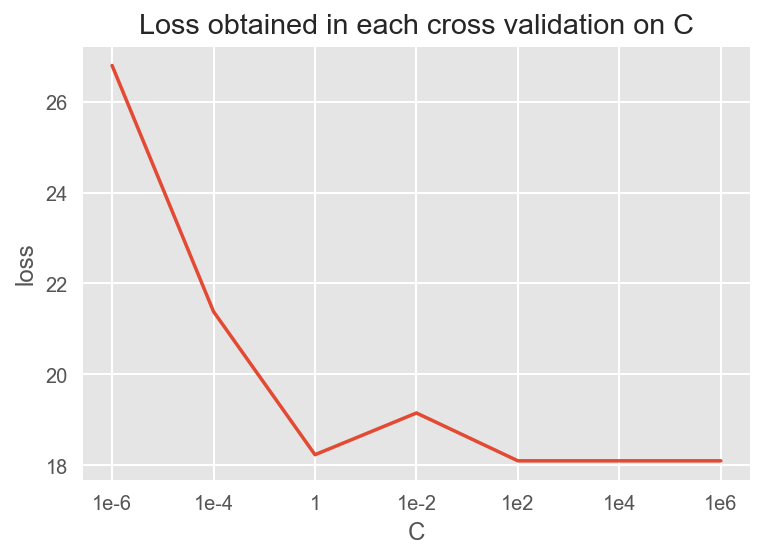

In [39]:
plt.figure(8)
plt.plot(['1e-6','1e-4','1','1e-2','1e2','1e4','1e6'],cross_c)
plt.title('Loss obtained in each cross validation on C')
plt.xlabel('C')
plt.ylabel('loss')
plt.show()

    Fig 8 - Loss obtained in each cross validation on C

\*C = 1e2 appears to be the best solution for this situation
<br>
The loss is about 18.

##### Conclusion & discussion
RandomForest is a better prediction in this situation. 
<br><br>
Logistic Regression is not performing good as it is linear with its predictive functions, and from  Figure 4 - Rental fee vs distance from MRT, the relationship between rental fee and distance is not linear. 
<br>
However, it can still achieve an accuracy of 48.31% because some of the features is in linear relationship (Figure 5 - Rental fee vs size of property).

### Example of other implication of this project
Situation: Assume I am interest in <b>1 bedroom</b>, <b>1 bathroom</b> rental house and I got a job near <b>EW14 Raffles Place</b>, what is the optimal distance which I should live from MRT station?

In [37]:
#size,bed,bath,distance,0,1,2,3,4,5,...,17,18,19,20,21,22,23,24,25,26
pred_class = []
for dist in np.linspace(0,1,100):
    x = [data_train_mean['size'],1,1,dist,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0]
    pred_class.append(clf.predict(((x-data_train_mean)/data_train_std).reshape(1, -1)))
    

C:\Users\Admin\Anaconda3\envs\CE9010_2018\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  """


Outcome of prediction base on my conditions:

In [74]:
np.unique(pred_class)

array([2, 4, 5, 6], dtype=int64)

Base on my conditions, the minimum price range I could get is class 2 (S$ 1001-1500)

In [69]:
min_cost = np.min(pred_class)
min_cost_index = [i for i, j in enumerate(pred_class) if j == min_cost]
np.linspace(0,1,100)[min_cost_index].min()

0.7474747474747475

<b>Conclusion</b>: 0.75 km is the optimal distance from EW14 Raffles Place for me to fulfill my condition (1 bedroom, 1 bathroom, the house is in mean size, and staying near Raffles Place MRT station).

Text(0,0.5,'Price Range class')

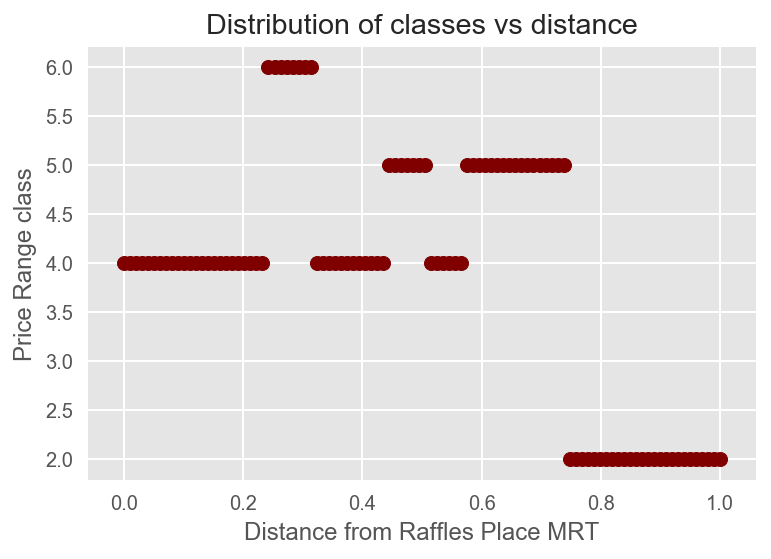

In [260]:
plt.figure(9)
plt.scatter(np.linspace(0,1,100),pred_class,color='maroon')
plt.title("Distribution of classes vs distance")
plt.xlabel('Distance from Raffles Place MRT')
plt.ylabel('Price Range class')

    Fig 9 - Distribution of classes vs distance

The result match with the intuition that staying further from MRT stations, resulting in lower rental fee. (The rental fee for staying between 0.8km to 1km from Raffles Place MRT station is only S$ 1001-1500 (class 2).

### Improvements & Discussions

There are some suggested improvements which I personally think can increase the accuracy:
<ol>
    <li> There is some information I am not using in this report, namely, <b>details</b> which denote the conditions of the property on whether the property is <b>fully furnished, partial furnished</b> or etc. As the information stated there is quite messy, and a text mining skill will be required and it increase the complexity of the projects, it is not being solved.</li>
    <li> Data size could be increased. Here, I use 10k data to classify 10 classes, i.e. roughly 1k samples for each class. Moreover, the sample is not evenly distributed. Resulting in slighly class-imbalancing issue. More data should be crawled from various website, for example, <a href='https://www.99.co/'>99.co</a>, <a href='https://www.iproperty.com.sg/?gclid=CjwKCAjwk9HWBRApEiwA6mKWaffEElKRLexZIRLT155Gi7IygcQWkArRlKSvjO7PhC6rHz-OoLZhBBoC0TAQAvD_BwE'>iProperty</a> instead of just focusing on PropertyGuru.</li>
    <li> Class imbalancing problem occurred but not being solved. As you might notice, I have a lot of samples in class 4 and class 9 (around 2500), only 2 records in class 0 *(Fig 3 - Number of samples in each class)*. Resulting in the accuracy in prediction of class 0 at 0% in logistic regression.</li>
    <li> I only consider Singapore East-West line MRT station. Which could be generalized to North-East line, Circle line and etc.</li>
</ol>